# Machine Learning Discussion Meeting - Interactive Notebook

In this notebook, we will implement some of the various techniques discussed in the talk "Machine Learning: Concepts and Applications".

*To install the requirements, please follow the instructions in the readme.*

This notebook is composed of 4 parts:

1. We will build a deep convolutional neural network to classify handwritten digits.

2. Next, we will build a deep convolutional autoencoder to build a compression algorithm for the handwritten digits.

3. We will use a previously generated dataset to train a deep learning model to solve the Schrödinger Equation and build the total energy as a functional of the external potential for one-electron model systems. 

4. Finally, the same model will be used to build the total energy as a functional of the charge density to compared with part 3.

 ## 1. Deep Convolutional Neural Network to Classify Handwritten Digits.

First, we will import the MNIST dataset of handwritten digits. This dataset consists of 70,000 28x28 grayscale images, along with the value in the image (0-9).

We will then split this into 60,000 training examples, 5000 validation examples, and 5000 test examples.

As we want to predict probabilities that the image contains each digit, we will convert the value to a caegorical value using one-hot encoding. e.g 7 -> [0,0,0,0,0,0,0,1,0,0]

The input data to the network should be normalised, we will normalise the images by dividing by 255 (the maximum value of 8-bit pixel data).maximum

We can then print the shapes of the data to make sure everything seems correct.

In [2]:
# Imports.
import pickle
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt


# # Set up GPU. [Uncomment this section if you have set up TensorFlow with the GPU on your system.]
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)


# Load in the dataset.
dataset = tf.keras.datasets.mnist


# Split the dataset into training, validation and testing data.
(x_train, y_train), (x_test, y_test) = dataset.load_data()
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_validation = x_test[:5000,...]
x_test = x_test[5000:,...]
y_validation = y_test[:5000,...]
y_test = y_test[5000:,...]


#  Convert the y values to categorical.
y_train = tf.keras.utils.to_categorical(y_train)
y_validation = tf.keras.utils.to_categorical(y_validation)
y_test = tf.keras.utils.to_categorical(y_test)


# Normalise the data.
x_train = x_train / 255.0
x_validation = x_validation / 255.0
x_test = x_test / 255.0


# Print the shapes of the data
print(x_train.shape, x_validation.shape, x_test.shape, y_train.shape, y_validation.shape, y_test.shape)

(60000, 28, 28, 1) (5000, 28, 28, 1) (5000, 28, 28, 1) (60000, 10) (5000, 10) (5000, 10)


We can now plot some of the test examples, to help visualise the data.

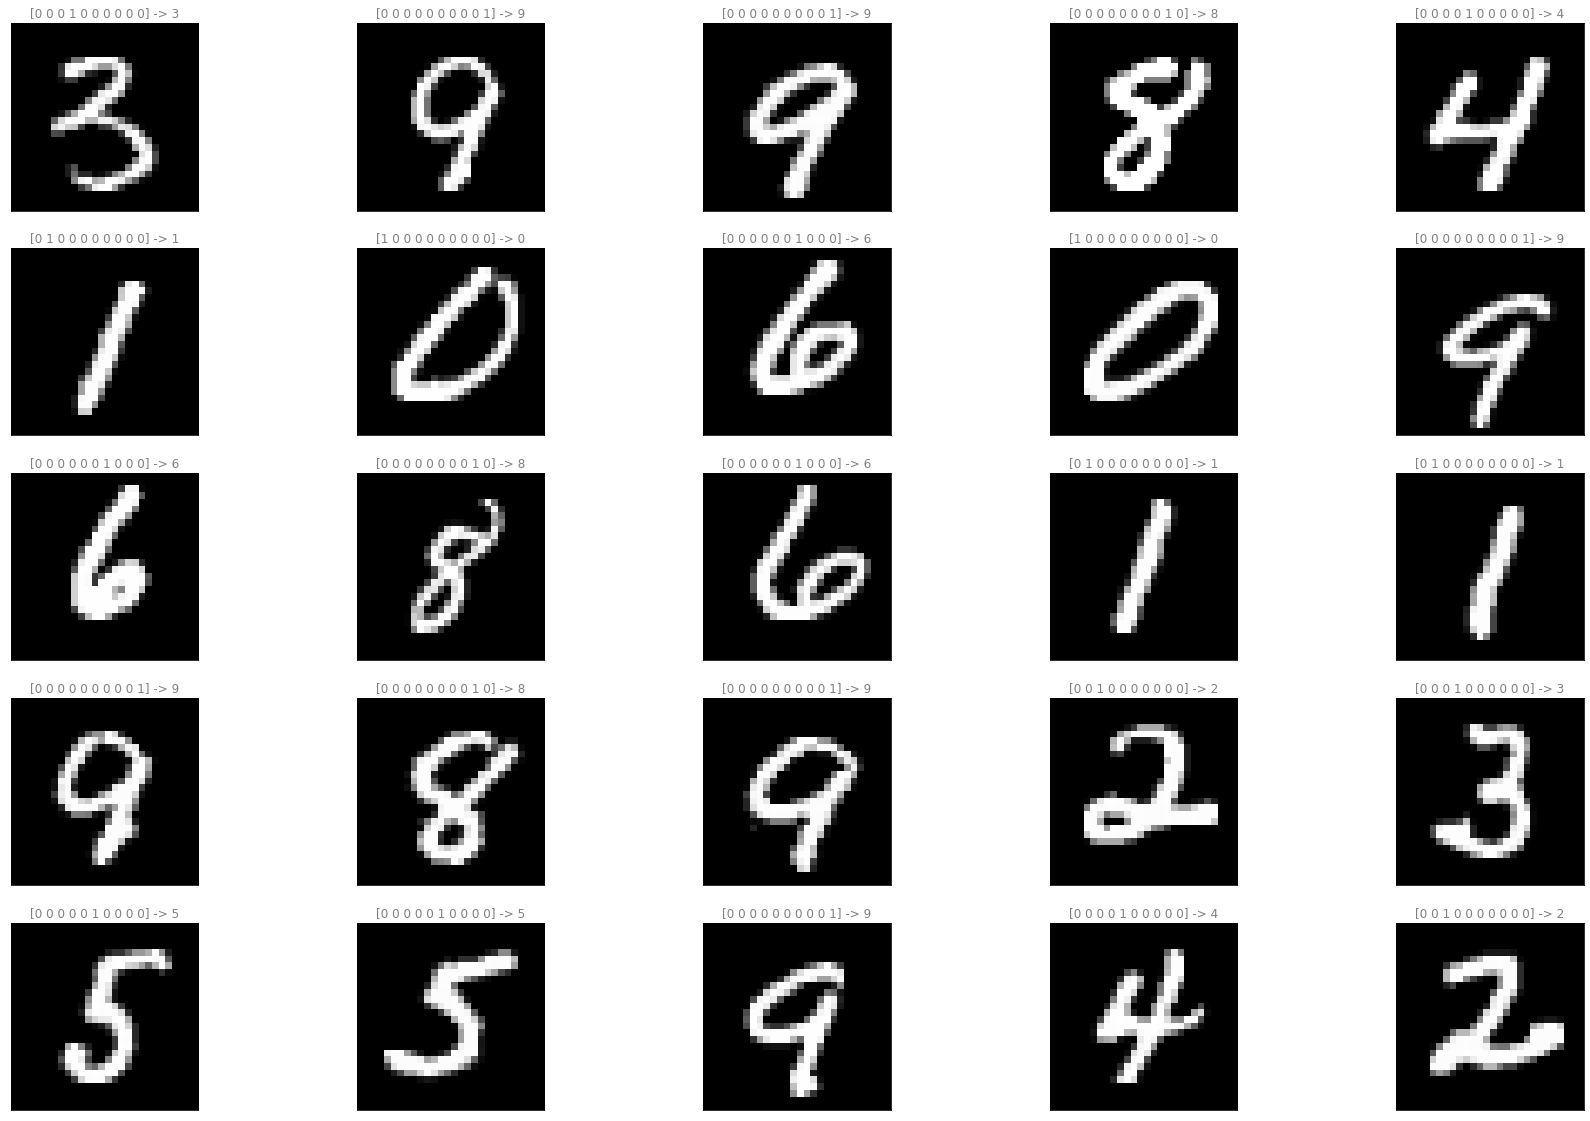

In [3]:
# Plot some results.
plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams['text.color'] = 'gray'
fig, axs = plt.subplots(5, 5)
k = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].imshow(x_test[k, :, :, :].reshape((28, 28)), cmap='gray')
        axs[i, j].set_title('{0} -> {1}'.format(y_test[k].astype(int), y_test[k].argmax()))
        axs[i, j].set_yticklabels([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        k = k + 1
plt.savefig('digits.pdf')

We will next define the following structure of the neural network:

![](model.png)

The input will be the image, the output will be the 10 probabilities.

In [4]:
# Build the neural network.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=84, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
model.summary()


# Complile the model.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 6)         60        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        880       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 100)               4

Next, we will train the model.

The number of **epochs** defines how many times the model will see the *whole* dataset. The **batch size** defines how many examples will be used to update the model each step. *In principle we would like the whole dataset, but we are limited by the memory on the GPU.* And we can chose to **shuffle** the data with each epoch.

In [5]:
# Train the model.
training = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=5, batch_size=250, shuffle=True)

Epoch 1/5
240/240 [==============================] - 8s 32ms/step - loss: 0.4407 - accuracy: 0.8748 - val_loss: 0.1723 - val_accuracy: 0.9484
Epoch 2/5
240/240 [==============================] - 7s 31ms/step - loss: 0.1084 - accuracy: 0.9666 - val_loss: 0.1082 - val_accuracy: 0.9662
Epoch 3/5
240/240 [==============================] - 8s 31ms/step - loss: 0.0800 - accuracy: 0.9755 - val_loss: 0.0873 - val_accuracy: 0.9722
Epoch 4/5
240/240 [==============================] - 8s 31ms/step - loss: 0.0654 - accuracy: 0.9796 - val_loss: 0.0801 - val_accuracy: 0.9726
Epoch 5/5
240/240 [==============================] - 8s 32ms/step - loss: 0.0565 - accuracy: 0.9828 - val_loss: 0.0685 - val_accuracy: 0.9776


As we will **not further modify the model**, we can apply it to the test set.

In [6]:
# Evaluate the model.
model.evaluate(x_test, y_test, verbose=2)

157/157 - 1s - loss: 0.0266 - accuracy: 0.9916 - 696ms/epoch - 4ms/step


[0.026573285460472107, 0.991599977016449]

We can now visualise the predictions made by the model on the test set.

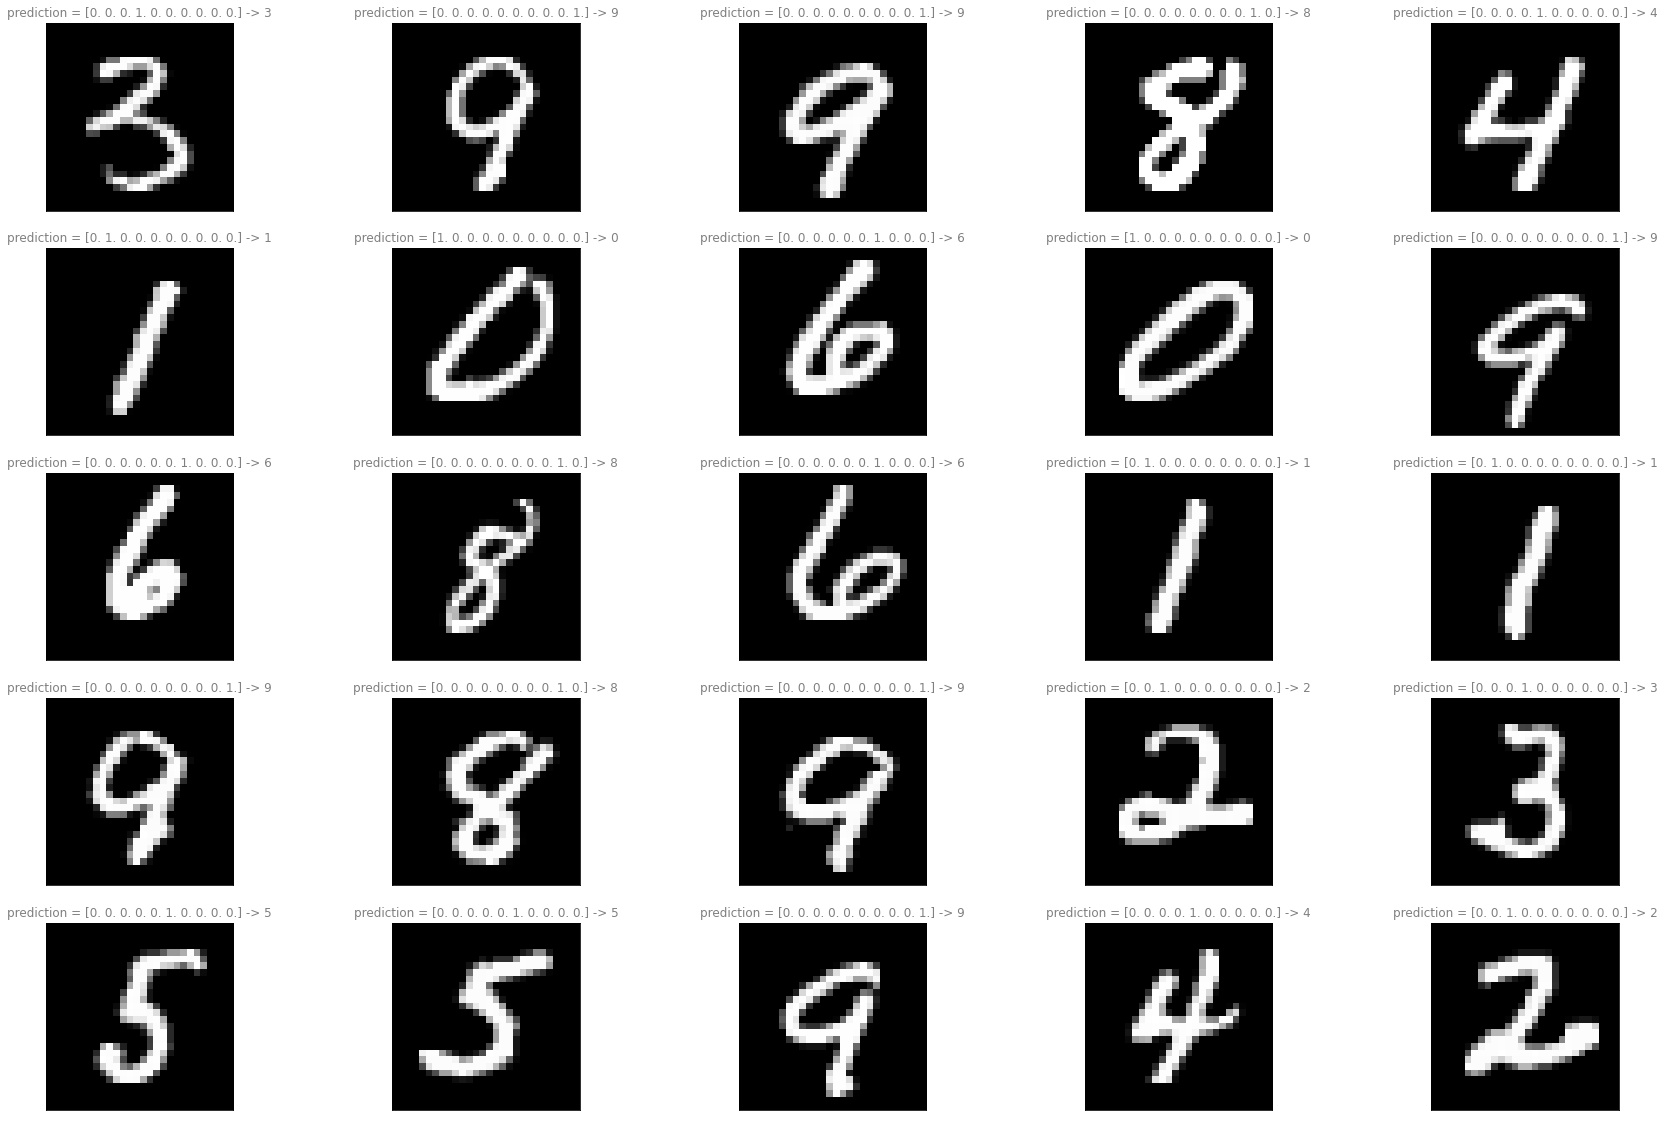

In [7]:
# Predict using the model.
N = 25 # Number of test images to predict
y_pred = model.predict(x_test[:N, :, :])


# Plot some results.
plt.rcParams['figure.figsize'] = [30, 20]
fig, axs = plt.subplots(5, 5)
k = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].imshow(x_test[k, :, :, :].reshape((28, 28)), cmap='gray')
        axs[i, j].set_title('prediction = {0} -> {1}'.format(y_pred[k].round(2), y_pred[k].argmax()))
        axs[i, j].set_yticklabels([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        k = k + 1
plt.savefig('predictions.pdf')

## 2. Deep Convolutional Autoencoder

In order to build a custom compression algorithm for these images, we train a deep convolutional autoencoder:

![](auto.png)

Play around with the values of the hyperparameters and the structure of the model to see how it affects the performance. And how small you can make the latent space (compressed image size). 

It is worth noting that we split the model into two parts, the encoder and decoder. This enables us to compress and decompress the images seperatly.

In [8]:
# Hyperparameters
optimizer = 'adadelta'
learning_rate = 1.0
epochs = 30
batch_size = 128
loss = 'mse'
shuffle = True


# Build the model.
input_img = tf.keras.layers.Input(shape=(28, 28, 1))
encoded = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = tf.keras.layers.Conv2D(2, (3, 3), activation='relu', padding='same')(encoded)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
latent_shape = (int(encoded.shape[1]), int(encoded.shape[2]), int(encoded.shape[3]))
print(latent_shape)
decoded = tf.keras.layers.Conv2D(2, (3, 3), activation='relu', padding='same')(encoded)
decoded = tf.keras.layers.UpSampling2D((2, 2))(decoded)
decoded = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
decoded = tf.keras.layers.UpSampling2D((2, 2))(decoded)
decoded = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(decoded)
decoded = tf.keras.layers.UpSampling2D((2, 2))(decoded)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)
autoencoder = tf.keras.models.Model(input_img, decoded)


# Print the model architecture.
autoencoder.summary()


# Define the encoder.
encoder = tf.keras.models.Model(input_img, encoded)


# Define the decoder.
encoded_input = tf.keras.layers.Input(shape=latent_shape)
decoder_layers = len(autoencoder.layers) - len(encoder.layers)
for i in range(decoder_layers, 0, -1):
    decoder_layer = autoencoder.layers[-i]
    if i == decoder_layers:
        nest = decoder_layer(encoded_input)
    else:
        nest = decoder_layer(nest)
decoder = tf.keras.models.Model(encoded_input, nest)


# Compile the autoencoder.
if optimizer == 'adam':
    opt = tf.keras.optimizers.Adam(lr=learning_rate)
if optimizer == 'sgd':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.1)
if optimizer == 'adadelta':
    opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
autoencoder.compile(optimizer=opt, loss=loss)
latent_shape = tuple(encoder.layers[-1].output_shape[1:4])

(4, 4, 2)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 2)       

We can now train the autoencoder, by using the images as the input and output of the model.

In [9]:
# Train the autoencoder.
training = autoencoder.fit(x_train, x_train, validation_data=(x_validation, x_validation), epochs=epochs, batch_size=batch_size, shuffle=shuffle)

Epoch 1/30
469/469 [==============================] - 41s 87ms/step - loss: 0.0671 - val_loss: 0.0494
Epoch 2/30
469/469 [==============================] - 41s 88ms/step - loss: 0.0473 - val_loss: 0.0467
Epoch 3/30
469/469 [==============================] - 41s 86ms/step - loss: 0.0428 - val_loss: 0.0392
Epoch 4/30
469/469 [==============================] - 40s 86ms/step - loss: 0.0403 - val_loss: 0.0379
Epoch 5/30
469/469 [==============================] - 43s 91ms/step - loss: 0.0382 - val_loss: 0.0365
Epoch 6/30
469/469 [==============================] - 41s 88ms/step - loss: 0.0366 - val_loss: 0.0349
Epoch 7/30
469/469 [==============================] - 42s 89ms/step - loss: 0.0350 - val_loss: 0.0342
Epoch 8/30
469/469 [==============================] - 42s 89ms/step - loss: 0.0337 - val_loss: 0.0321
Epoch 9/30
469/469 [==============================] - 41s 86ms/step - loss: 0.0327 - val_loss: 0.0310
Epoch 10/30
469/469 [==============================] - 41s 88ms/step - loss: 0.031

In [10]:
# Encode and then decode some test data.
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Plotting the training we can see that the model is not overfitting, and that further epochs would improve model performance.

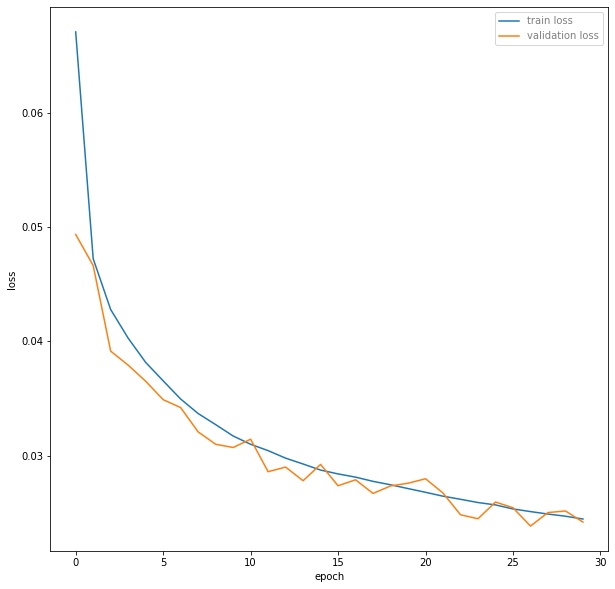

In [11]:
# plotting the training
train_loss = np.array(training.history['loss'])
test_loss = np.array(training.history['val_loss'])
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('training.pdf')

We can now investigate how well the decompressed images recover the original image for some test examples:

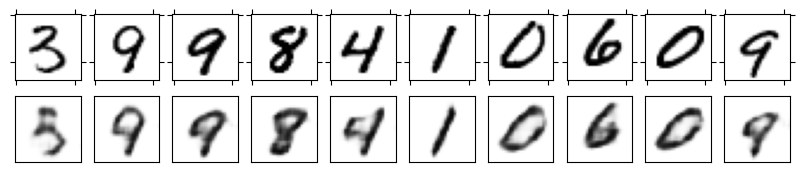

In [12]:
# Plot the decoded test data.
n = 10
vmax = np.max(np.abs(x_test))
vmin = -np.max(np.abs(x_test))
plt.figure(figsize=(10, 2), dpi=100)
for i in range(10):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i,:,:,0], norm=plt.Normalize(0,vmax), cmap=matplotlib.cm.binary, interpolation='hamming')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs[i,:,:,0], norm=plt.Normalize(0,vmax), cmap=matplotlib.cm.binary, interpolation='hamming')
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
plt.savefig('auto_predictions.pdf')

We can also visualise the compressed images for each case. 

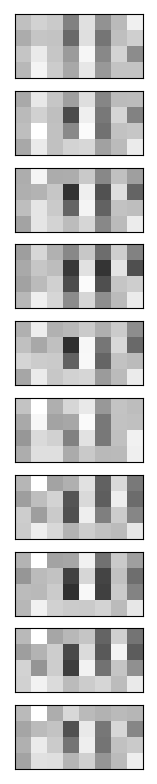

In [13]:
# Plot the latent spaces.
n = 10
vmax = np.max(np.abs(encoded_imgs))
vmin = -np.max(np.abs(encoded_imgs))
plt.figure(figsize=(10, 10), dpi=100)
for i in range(10):
    ax = plt.subplot(n, 1, i + 1)
    plt.imshow(np.reshape(encoded_imgs[i,:,:,:],(latent_shape[0],latent_shape[1]*latent_shape[2])), norm=plt.Normalize(0,vmax), cmap=matplotlib.cm.binary)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('latent.pdf')

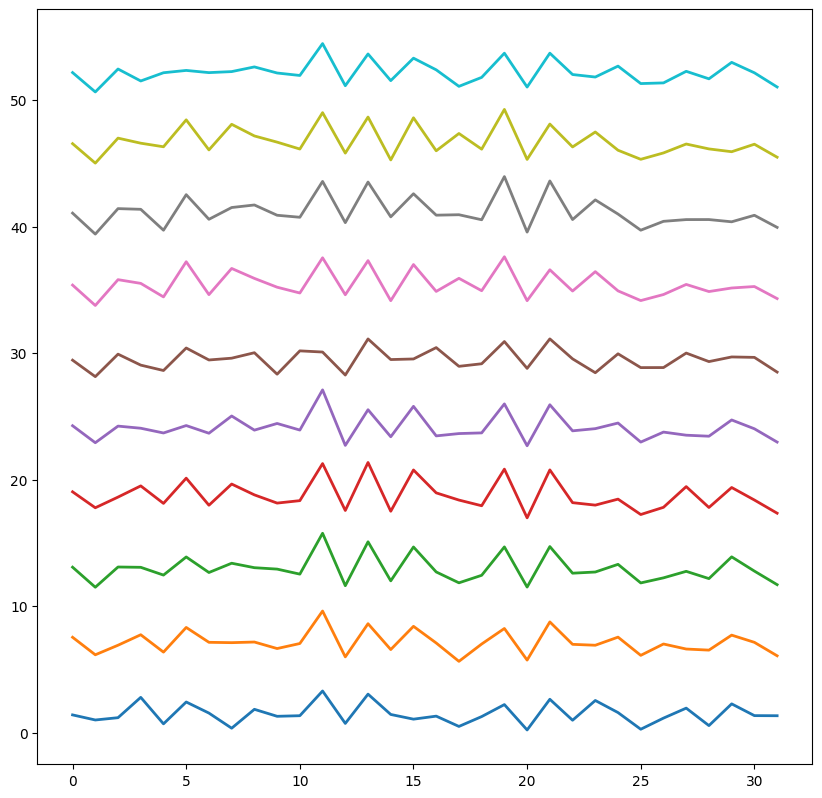

In [14]:
# Plot the flat latent spaces.
n = 10
shift = np.max(encoded_imgs)
plt.figure(figsize=(10, 10), dpi=100)
for i in range(10):
    plt.plot(np.reshape(encoded_imgs[i,:,:,:],(latent_shape[0]*latent_shape[1]*latent_shape[2]))+i*shift, label='${0}$'.format(i), linewidth=2.0)
plt.savefig('latent_flat.pdf')

## 3. Solving the Schrödinger Equation using Deep Learning

In the following code, we use the dataset of 100,000 one electron systems to train a deep neural network to solve the 1D one electron Schrödinger Equation for the ground state energy.

The dataset contains the ground-state charge density (black) and total energy (blue line) for 100,000 randomly generated external potentials (red) on a grid containing 64 points:


![](data.png)

In the following code we load in the data, perform the usual train, validation and testing split.

Then we build a convolutional (1D) network to predict the total energy from the external potential $E[V_\mathrm{ext}(x)]$

In [15]:
# Load in the dataset.
V = pickle.load(open('V.db','rb'))
n = pickle.load(open('density.db','rb'))
E = pickle.load(open('E.db','rb'))


# Split the dataset into training, validation and testing data.
V = V.reshape(V.shape + (1,))
n = n.reshape(n.shape + (1,))
E = E.reshape(E.shape + (1,))
V_train = V[:50000,...]
V_validation = V[50000:75000,...]
V_test = V[75000:,...]
n_train = n[:50000,...]
n_validation = n[50000:75000,...]
n_test = n[75000:,...]
E_train = E[:50000,...]
E_validation = E[50000:75000,...]
E_test = E[75000:,...]
print(V.shape, n.shape, E.shape)


# Build the neural network.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=(3), activation='relu', input_shape=(64, 1)))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=(3), activation='relu'))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))


# Complile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')


# Train the model.
training = model.fit(V_train, E_train, validation_data=(V_validation, E_validation), epochs=50, batch_size=250, shuffle=True)


# Evaluate the model.
model.evaluate(V_test, E_test, verbose=2)


# Predict using the model.
N = 25 # Number of test images to predict
E_pred = model.predict(V_test[:N, :, :])

(100000, 64, 1) (100000, 64, 1) (100000, 1)
Epoch 1/50
200/200 [==============================] - 2s 10ms/step - loss: 0.0380 - val_loss: 0.0057
Epoch 2/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0133 - val_loss: 0.0024
Epoch 3/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0019
Epoch 4/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0089 - val_loss: 0.0021
Epoch 5/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0079 - val_loss: 0.0013
Epoch 6/50
200/200 [==============================] - 2s 10ms/step - loss: 0.0073 - val_loss: 0.0017
Epoch 7/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0069 - val_loss: 9.2001e-04
Epoch 8/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0066 - val_loss: 0.0018
Epoch 9/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 10/50
200/200 [=============================

After training the model, we can plot the predictions (dotted cyan) against the true values of the energy (blue) for 25 of the test systems:

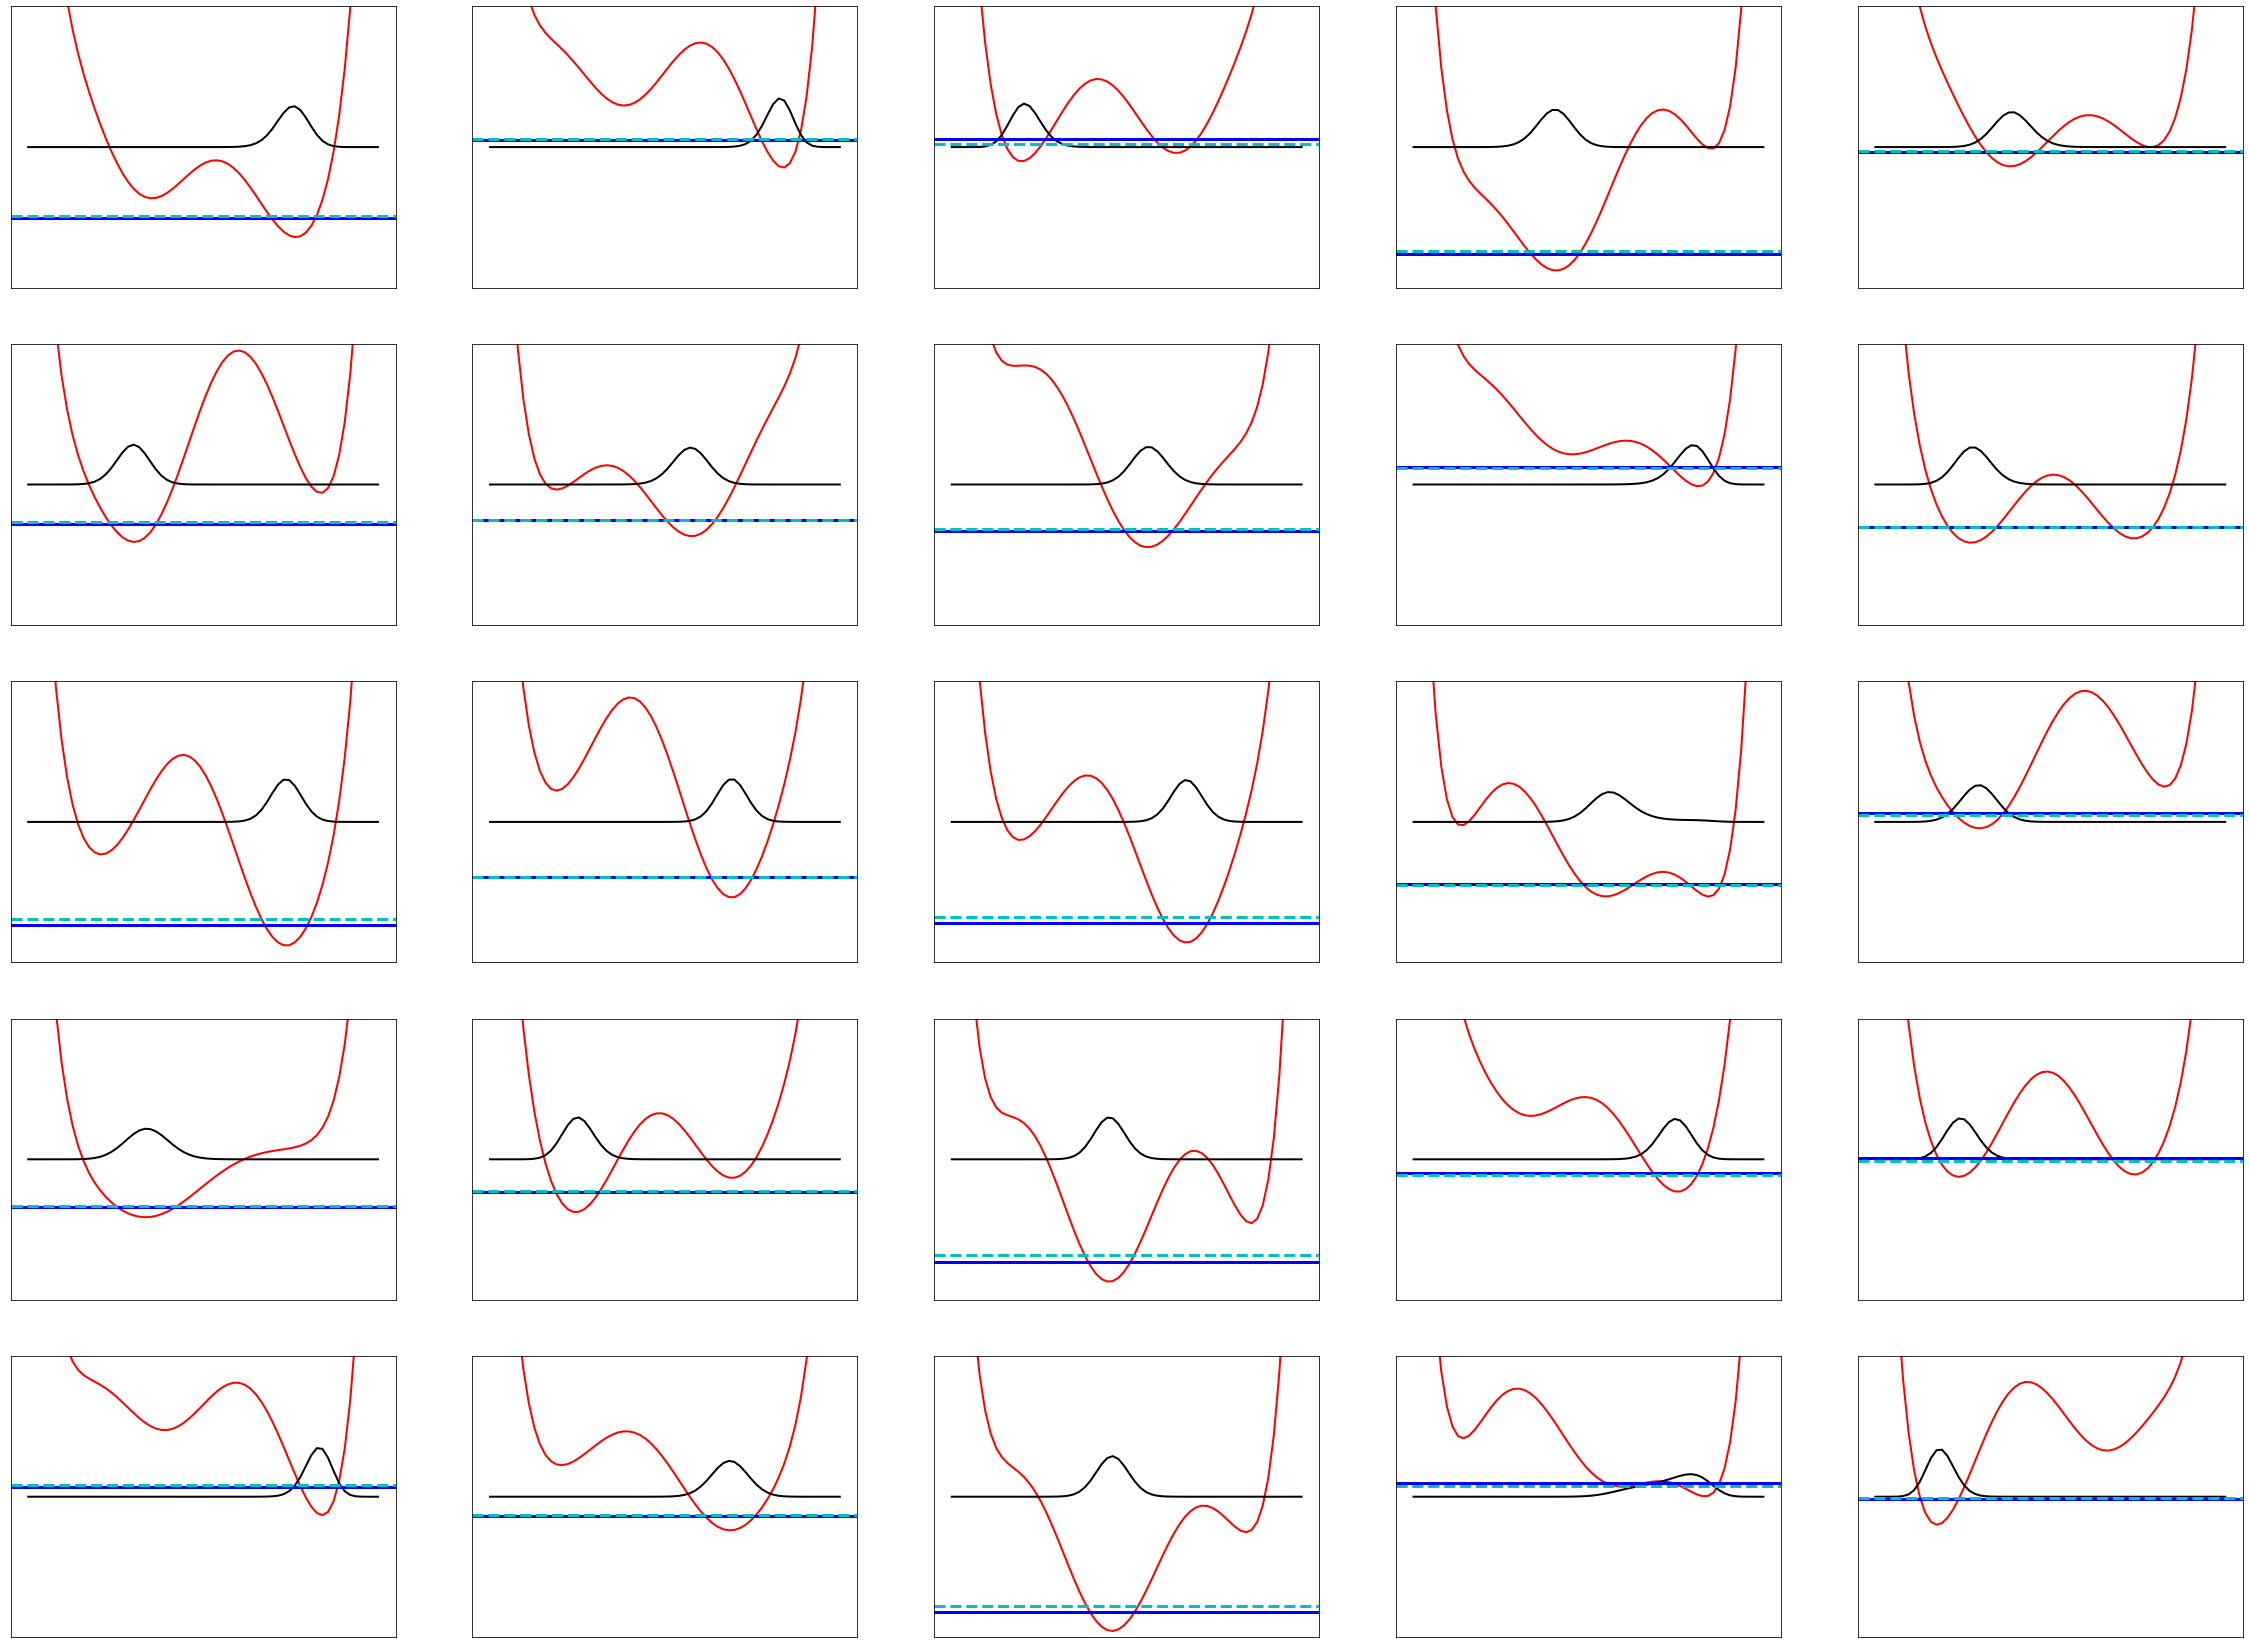

In [16]:
# Plot some results.
plt.rcParams['figure.figsize'] = [40, 30]
fig, axs = plt.subplots(5, 5)
k = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].plot(V_test[k, :, :].reshape(64,), 'r-', linewidth=2.0)
        axs[i, j].plot(n_test[k, :, :].reshape(64,), 'k-', linewidth=2.0)
        axs[i, j].axhline(E_test[k, 0], color='b', linewidth=3.0)
        axs[i, j].axhline(E_pred[k, 0], color='c', linestyle='--', linewidth=3.0)
        axs[i, j].set_ylim([-1,1])
        axs[i, j].set_yticklabels([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        k = k + 1
plt.savefig('v_predictions.pdf')

## 4. Learning the functional of the charge density.

We can now begin to investigate in a simple way, **of which quantity is it best to build a given functional from?**. We can take the *identical model* from above, that we used to train $E[V_\mathrm{ext}(x)]$, and use it to instead train $E[n(x)]$. Does this model yield better results? Is it harder to train?

In [17]:
# Build the neural network.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=(3), activation="relu", input_shape=(64, 1)))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=(3), activation="relu"))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=50, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=1, activation="linear"))


# Compile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")


# Train the model.
training = model.fit(n_train, E_train, validation_data=(n_validation, E_validation), epochs=50, batch_size=250, shuffle=True)


# Evaluate the model.
model.evaluate(n_test, E_test, verbose=2)


# Predict using the model.
N = 25 # Number of test images to predict
E_pred = model.predict(n_test[:N, :, :])

Epoch 1/50
200/200 [==============================] - 2s 10ms/step - loss: 0.1065 - val_loss: 0.0797
Epoch 2/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0869 - val_loss: 0.0775
Epoch 3/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0836 - val_loss: 0.0762
Epoch 4/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0812 - val_loss: 0.0743
Epoch 5/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0791 - val_loss: 0.0725
Epoch 6/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0766 - val_loss: 0.0705
Epoch 7/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0744 - val_loss: 0.0686
Epoch 8/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0729 - val_loss: 0.0673
Epoch 9/50
200/200 [==============================] - 2s 10ms/step - loss: 0.0713 - val_loss: 0.0668
Epoch 10/50
200/200 [==============================] - 2s 10ms/step - loss: 0.0706 - val_loss: 0.0

We can see that building a funtional of the density is more difficult for the machine to learn for an equivelent mode, why is this? (For example, a shift in the potential shifts the energy, but has no effect on the density.)

**Task: Can you modify the code above the produce a more accurate functional when applied to the test systems. Consider modifying the parameters of the model, such as the kernals of the convolutions, the number of dense layers, the learning rate, number of epochs ect...**

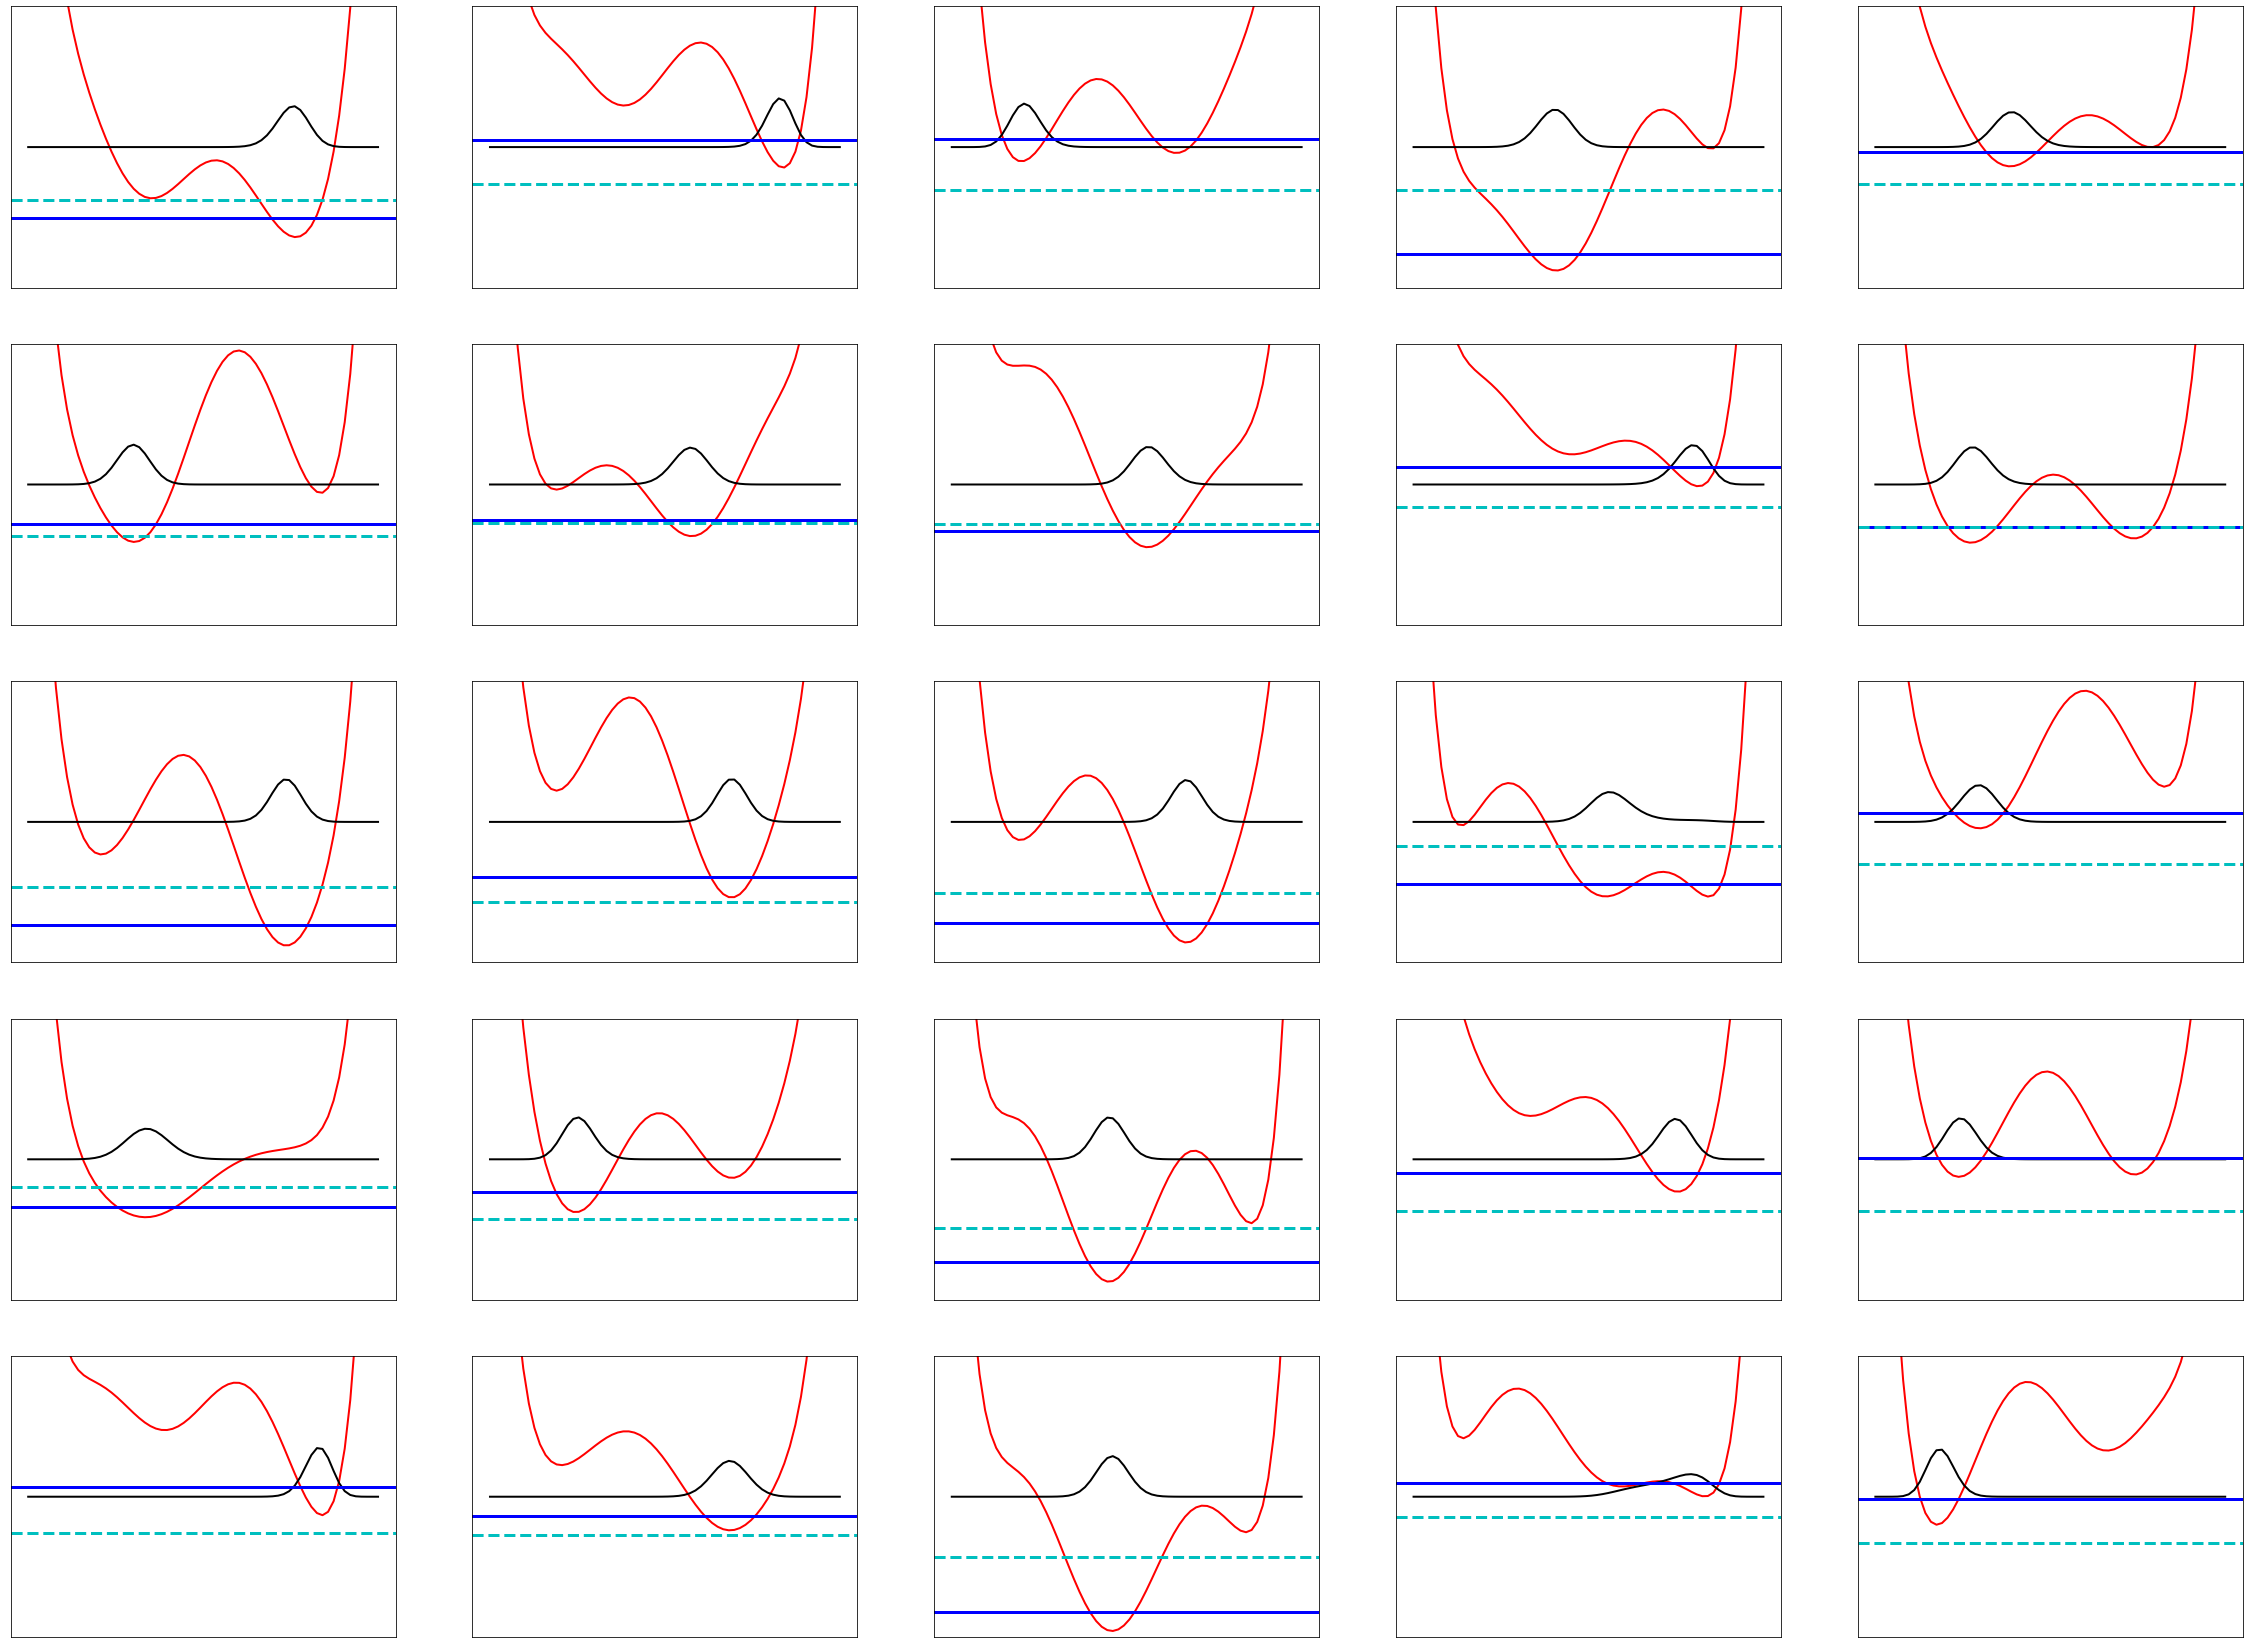

In [18]:
# Plot some results.
plt.rcParams['figure.figsize'] = [40, 30]
fig, axs = plt.subplots(5, 5)
k = 0
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].plot(V_test[k, :, :].reshape(64,), 'r-', linewidth=2.0)
        axs[i, j].plot(n_test[k, :, :].reshape(64,), 'k-', linewidth=2.0)
        axs[i, j].axhline(E_test[k, 0], color='b', linewidth=3.0)
        axs[i, j].axhline(E_pred[k, 0], color='c', linestyle='--', linewidth=3.0)
        axs[i, j].set_ylim([-1,1])
        axs[i, j].set_yticklabels([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        k = k + 1
plt.savefig('n_predictions.pdf')